# 0. Libraries

In [1]:
# Utilities
import asyncio
from dotenv import load_dotenv
import os
import json
from google import genai
import polars as pl
from neo4j_graphrag_custom.kg_builder import CustomKGPipeline, build_kg_from_df, GeminiLLM
from neo4j_graphrag.experimental.components.resolver import (
    SpaCySemanticMatchResolver, FuzzyMatchResolver, SinglePropertyExactMatchResolver
)
from tqdm.autonotebook import tqdm as notebook_tqdm

# Neo4j and Neo4j GraphRAG imports
import neo4j
from neo4j_graphrag.embeddings import SentenceTransformerEmbeddings

/tmp/ipykernel_34223/2997266868.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as notebook_tqdm


Let's first check the available Gemini models.

In [3]:
load_dotenv('.env', override=True)

gemini_api_key = os.getenv('GEMINI_API_KEY')

if gemini_api_key:
    client = genai.Client(api_key=gemini_api_key)  # Configure the API key for genai
else:
    raise ValueError("GEMINI_API_KEY environment variable is not set.")

# Display available models
for model in client.models.list():
    print(model)

name='models/embedding-gecko-001' display_name='Embedding Gecko' description='Obtain a distributed representation of a text.' version='001' endpoints=None labels=None tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None) input_token_limit=1024 output_token_limit=1 supported_actions=['embedText', 'countTextTokens'] default_checkpoint_id=None checkpoints=None
name='models/gemini-1.0-pro-vision-latest' display_name='Gemini 1.0 Pro Vision' description='The original Gemini 1.0 Pro Vision model version which was optimized for image understanding. Gemini 1.0 Pro Vision was deprecated on July 12, 2024. Move to a newer Gemini version.' version='001' endpoints=None labels=None tuned_model_info=TunedModelInfo(base_model=None, create_time=None, update_time=None) input_token_limit=12288 output_token_limit=4096 supported_actions=['generateContent', 'countTokens'] default_checkpoint_id=None checkpoints=None
name='models/gemini-pro-vision' display_name='Gemini 1.0 Pro Vi

We also have to make sure that the corresponding SpaCy model for text embedding used at the resolving step is installed.

In [2]:
import spacy
import importlib.util
import subprocess
import sys

def ensure_spacy_model(model_name):
    if importlib.util.find_spec(model_name) is None:
        print(f"Model '{model_name}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
    else:
        print(f"Model '{model_name}' is already installed.")

# Use it for 'en_core_web_lg'
ensure_spacy_model("en_core_web_lg")  # Model used for resolving entities in the KG pipeline

Model 'en_core_web_lg' is already installed.


In [ ]:
with open('kg_building_config.json', 'r') as f:
    config = json.load(f)

config['examples_config']

{'pass_examples': False,
 'examples': [{'input_text': "Text: On January 1, 2023, a significant conflict erupted in the Middle East involving multiple countries and organizations. The conflict, named 'Middle East Conflict 2023', lasted until March 15, 2023. Key actors included the 'Middle East Coalition' and the 'Opposing Forces'. The conflict resulted in a high level of destruction and instability in the region.",
   'schema': {'nodes': [{'id': '0',
      'label': 'Event',
      'properties': {'name': 'Middle East Conflict 2023',
       'date': '2023-01-01',
       'end_date': '2023-03-15',
       'type': 'Conflict',
       'severity': 5,
       'description': 'A significant conflict in the Middle East.'}},
     {'id': '1',
      'label': 'Actor',
      'properties': {'name': 'Middle East Coalition', 'type': 'Organization'}},
     {'id': '2',
      'label': 'Actor',
      'properties': {'name': 'Opposing Forces', 'type': 'Organization'}},
     {'id': '3',
      'label': 'Region',
     

In [10]:
print(config['examples_config']['examples'])

[{'input_text': "Text: On January 1, 2023, a significant conflict erupted in the Middle East involving multiple countries and organizations. The conflict, named 'Middle East Conflict 2023', lasted until March 15, 2023. Key actors included the 'Middle East Coalition' and the 'Opposing Forces'. The conflict resulted in a high level of destruction and instability in the region.", 'schema': {'nodes': [{'id': '0', 'label': 'Event', 'properties': {'name': 'Middle East Conflict 2023', 'date': '2023-01-01', 'end_date': '2023-03-15', 'type': 'Conflict', 'severity': 5, 'description': 'A significant conflict in the Middle East.'}}, {'id': '1', 'label': 'Actor', 'properties': {'name': 'Middle East Coalition', 'type': 'Organization'}}, {'id': '2', 'label': 'Actor', 'properties': {'name': 'Opposing Forces', 'type': 'Organization'}}, {'id': '3', 'label': 'Region', 'properties': {'name': 'Middle East', 'stability': 0.2}}], 'relationships': [{'type': 'OCCURRED_IN', 'start_node_id': '0', 'end_node_id': 

# 1. Loading the data

The data is loaded here as a reference, but it is loaded again inside the pipeline below.

In [16]:
notebook_dir = os.getcwd()

# Load data
df_path = os.path.join(notebook_dir, 'FILTERED_DATAFRAME.parquet')
df = pl.read_parquet(df_path)

df.head()

state,date,month_year,year,event_code,quad_class,goldstein_scale,avg_tone,actor1_statecode,actor2_statecode,url,title,full_text
str,i64,i64,i64,i64,i64,f64,f64,str,str,str,str,str
"""USMO""",20210514,202105,2021,16,1,-2.0,-8.934073,"""USMO""","""USMO""","""https://www.natlawreview.com/a…","""State of the Law for Business …","""It’s been a year since COVID-1…"
"""USMO""",20210514,202105,2021,141,3,-6.5,-0.808625,"""USMO""","""USMO""","""https://www.kcur.org/health/20…","""Medicaid Expansion Supporters …","""A day after Missouri Gov. Mike…"
"""USMO""",20210529,202105,2021,13,1,0.4,-6.008584,"""USMO""","""USMO""","""https://www.dailystar.co.uk/ne…","""Elderly woman sucker-punched t…","""Elderly woman sucker-punched t…"
"""USAR""",20200207,202002,2020,16,1,-2.0,-8.0,"""USAR""",null,"""https://www.houstonchronicle.c…",null,null
"""USNH""",20201206,202012,2020,70,2,7.0,0.088106,"""USNH""","""USNH""","""https://www.fosters.com/story/…","""Historically Speaking: Adventu…","""Historically Speaking: Adventu…"


There are three fields that can be useful as document metadata:
1. The `title` of the article.
2. The `date` when the article was published.
3. Its `url`.

Let's convert the date to a datetime type.

In [9]:
# First, convert the 'date' column to string format
df = df.with_columns(pl.col('date').cast(pl.String))

# Convert date column to datetime
df = df.with_columns(pl.col('date').str.strptime(pl.Date, format='%Y%m%d'))

df.head()

state,date,month_year,year,event_code,quad_class,goldstein_scale,avg_tone,actor1_statecode,actor2_statecode,url,title,full_text
str,date,i64,i64,i64,i64,f64,f64,str,str,str,str,str
"""USMO""",2021-05-14,202105,2021,16,1,-2.0,-8.934073,"""USMO""","""USMO""","""https://www.natlawreview.com/a…","""State of the Law for Business …","""It’s been a year since COVID-1…"
"""USMO""",2021-05-14,202105,2021,141,3,-6.5,-0.808625,"""USMO""","""USMO""","""https://www.kcur.org/health/20…","""Medicaid Expansion Supporters …","""A day after Missouri Gov. Mike…"
"""USMO""",2021-05-29,202105,2021,13,1,0.4,-6.008584,"""USMO""","""USMO""","""https://www.dailystar.co.uk/ne…","""Elderly woman sucker-punched t…","""Elderly woman sucker-punched t…"
"""USAR""",2020-02-07,202002,2020,16,1,-2.0,-8.0,"""USAR""",null,"""https://www.houstonchronicle.c…",null,null
"""USNH""",2020-12-06,202012,2020,70,2,7.0,0.088106,"""USNH""","""USNH""","""https://www.fosters.com/story/…","""Historically Speaking: Adventu…","""Historically Speaking: Adventu…"


In [5]:
# Keep a subset of rows for testing
df = df.head(100)

# 2. Running the pipeline

In [ ]:
# Open configuration file
script_dir = os.getcwd()
config_path = os.path.join(script_dir, 'kg_building_config.json')
with open(config_path, 'r') as config_file:
    config = json.load(config_file)
prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None
print(prompt_template)

You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph that will be used for creating security reports for different countries.

Extract the entities (nodes) and specify their type from the following Input text.
Also extract the relationships between these nodes. The relationship direction goes from the start node to the end node.

Return result as JSON using the following format:
{{"nodes": [ {{"id": "0", "label": "the type of entity", "properties": {{"name": "name of entity" }} }}],
"relationships": [{{"type": "TYPE_OF_RELATIONSHIP", "start_node_id": "0", "end_node_id": "1", "properties": {{"details": "Description of the relationship"}} }}] }}

- Use only the information from the Input text. Do not add any additional information.
- If the input text is empty, return empty Json.
- Make sure to create as many nodes and relationships as needed to offer rich context for generating a security-related knowledge graph.
- An AI knowl

## 2.1. With a single text string

In [ ]:
# Example usage with a single text string
async def process_single_text():
    # Load configuration and setup
    script_dir = os.getcwd()
    
    # Load environment variables
    dotenv_path = os.path.join(script_dir, '.env')
    load_dotenv(dotenv_path, override=True)
    
    # Open configuration file
    config_path = os.path.join(script_dir, 'kg_building_config.json')
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    
    # Neo4j connection
    neo4j_uri = os.getenv('NEO4J_URI')
    neo4j_username = os.getenv('NEO4J_USERNAME')
    neo4j_password = os.getenv('NEO4J_PASSWORD')
    gemini_api_key = os.getenv('GEMINI_API_KEY')
    
    if not gemini_api_key:
        raise ValueError("Gemini API key is not set. Please provide a valid API key.")
    
    # Initialize LLM
    llm = GeminiLLM(
        model_name=config['llm_config']['model_name'],
        google_api_key=gemini_api_key,
        model_params=config['llm_config']['model_params']
    )
    
    # Configure text splitter
    text_splitter_config = config['text_splitter_config']
    
    # Initialize embedder
    embedder = SentenceTransformerEmbeddings(model=config['embedder_config']['model_name'])

    # Sample text to process - using a short example for testing
    sample_text = """The Secretary-General strongly condemns the attacks on 15 January against the United Nations 
    Multidimensional Integrated Stabilization Mission in Mali (MINUSMA) in Aguelhok, Kidal region. The attacks 
    resulted in the death of four peacekeepers from Chad and serious injuries to nineteen others."""
    
    # Document information
    document_title = "UN Secretary-General Condemns Attack on Peacekeepers in Mali"
    document_metadata = {
        "source": "https://www.un.org/press/en/example-url.html",
        "published_date": "2021-01-16"
    }
    document_id = "test_doc_001"
    
    # Create the pipeline using a with statement for proper resource management
    with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:

        # Initialize entity resolver
        resolver = SpaCySemanticMatchResolver(  # Merge nodes with same label and similar textual properties
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_properties=["name"],  # Properties to use for resolution (default is "name")
            similarity_threshold=0.8,  # The similarity threshold above which nodes are merged (default is 0.8). Higher threshold will result in less false positives, but may miss some matches. 
            spacy_model="en_core_web_lg"  # spaCy model to use for resolution (default is "en_core_web_lg")
        )

        # Initialize the custom KG pipeline
        kg_pipeline = CustomKGPipeline(
            llm=llm,
            driver=driver,
            embedder=embedder,
            schema_config=config['schema_config'],
            prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None,
            text_splitter_config=text_splitter_config,
            resolver=resolver,
            on_error='RAISE',
            batch_size=1000,
            max_concurrency=5,
            examples=""
        )
        
        print("Pipeline initialized successfully. Processing text...")
        
        # Process the single text with the pipeline
        result = await kg_pipeline.run_async(
            text=sample_text,
            document_base_field=document_title,
            document_metadata=document_metadata,
            document_id=document_id
        )
        
        print("Text processing complete.")
    
    return result

# Run the function
print("Starting single text processing...")
result = await process_single_text()
print(f"Pipeline completed with result: {result}")

# Optional: If you want to see details of what was created in the knowledge graph
if result and hasattr(result, 'stats'):
    print("\nKG Creation Statistics:")
    for key, value in result.stats.items():
        print(f"  {key}: {value}")

Starting single text processing...


/home/pablo/miniconda3/envs/thesis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pipeline initialized successfully. Processing text...
Text processing complete.
Pipeline completed with result: run_id='c58760b7-8218-4ca0-9e34-f0d7a4939e21' result={'resolver': {'number_of_nodes_to_resolve': 8, 'number_of_created_nodes': 0}}


## 2.2. With a data frame

### A. Using the `SpaCySemanticMatchResolver`

More useful information about the resolvers can be found in the [user guide](https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html#entity-resolver). Below, we use different resolvers (from the most aggressive - spaCy to the most conservative - exact matching) to get a broad overview of the performance results.

In [2]:
# Example usage code
async def main():

    # Load configuration and setup

    script_dir = os.getcwd()

    # script_dir = os.path.dirname(os.path.abspath(__file__))  # Uncomment if running as a script

    # Load environment variables from a .env file
    dotenv_path = os.path.join(script_dir, '.env')
    load_dotenv(dotenv_path, override=True)

    # Open configuration file from JSON format
    config_path = os.path.join(script_dir, 'kg_building_config.json')
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    
    # Neo4j connection
    neo4j_uri = os.getenv('NEO4J_URI')
    neo4j_username = os.getenv('NEO4J_USERNAME')
    neo4j_password = os.getenv('NEO4J_PASSWORD')
    gemini_api_key = os.getenv('GEMINI_API_KEY')
    
    # Check if gemini_api_key is set
    if gemini_api_key:
        pass
    else:
        raise ValueError("Gemini API key is not set. Please provide a valid API key.")

    # Initialize LLM
    llm = GeminiLLM(
        model_name=config['llm_config']['model_name'],
        google_api_key=gemini_api_key,
        model_params=config['llm_config']['model_params']
    )
    
    # Initialize embedder
    embedder = SentenceTransformerEmbeddings(model=config['embedder_config']['model_name'])
    
    # Configure text splitter
    text_splitter_config = config['text_splitter_config']
    
    # Load data
    df_path = os.path.join(script_dir, 'FILTERED_DATAFRAME.parquet')
    df = pl.read_parquet(df_path)

    # Convert 'date' column to string format (from YYYYMMDD to YYYY-MM-DD)
    df = df.with_columns(pl.col('date').cast(pl.String))
    df = df.with_columns(pl.col('date').str.strptime(pl.Date, format='%Y%m%d'))
    df = df.with_columns(pl.col('date').dt.strftime('%Y-%m-%d'))

    # Create subset of the dataframe for testing
    df = df.head(10)
    
    # Create the pipeline - use with statement to ensure proper resource management
    # and to ensure the driver is closed after use
    with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:
        
        # Initialize entity resolver
        resolver = SpaCySemanticMatchResolver(  # Merge nodes with same label and similar textual properties
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_properties=["name"],  # Properties to use for resolution (default is "name")
            similarity_threshold=0.8,  # The similarity threshold above which nodes are merged (default is 0.8). Higher threshold will result in less false positives, but may miss some matches. 
            spacy_model="en_core_web_lg"  # spaCy model to use for resolution (default is "en_core_web_lg")
        )

        # Initialize the custom KG pipeline
        kg_pipeline = CustomKGPipeline(
            llm=llm,
            driver=driver,
            embedder=embedder,
            schema_config=config['schema_config'],
            prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None,
            text_splitter_config=text_splitter_config,
            resolver=resolver,
            examples_config=None,  # Use None if no examples are provided
            on_error='RAISE',
            batch_size=1000,
            max_concurrency=5
        )
        
        # Define metadata mapping (document properties additional to base field 
        # to dataframe columns)
        metadata_mapping = {
            "source": "url",
            "published_date": "date"
        }
        
        # Process the dataframe
        results = await build_kg_from_df(
            kg_pipeline=kg_pipeline,
            df=df,
            document_base_field='title',
            text_column='full_text',
            document_metadata_mapping=metadata_mapping,
            document_id_column=None  # Use default document ID generation
        )
    
    return results

# Asyncio event loop to run the main function in a Jupyter notebook
results = await main()
print(f"Processed {len(results)} documents")

# # Asyncio event loop to run the main function in a script
# if __name__ == "__main__":
#     results = asyncio.run(main())
#     print(f"Processed {len(results)} documents")

Processing row 1 of 10
Result: run_id='9eefcf4f-77d7-421c-886f-ddd7616406c9' result={'resolver': {'number_of_nodes_to_resolve': 24, 'number_of_created_nodes': 2}}
Elapsed time: 16.40 seconds
Estimated time remaining: 147.63 seconds

Processing row 2 of 10
Result: run_id='5cf3c2b0-1cfd-485b-ada2-ad1d17fd4f86' result={'resolver': {'number_of_nodes_to_resolve': 48, 'number_of_created_nodes': 3}}
Elapsed time: 33.81 seconds
Estimated time remaining: 135.25 seconds

Processing row 3 of 10
Result: run_id='91b498ba-40c0-468d-ab45-3145c9b96657' result={'resolver': {'number_of_nodes_to_resolve': 54, 'number_of_created_nodes': 2}}
Elapsed time: 38.65 seconds
Estimated time remaining: 90.18 seconds

Processing row 4 of 10
Skipping row 4 due to empty text
Elapsed time: 38.65 seconds
Estimated time remaining: 57.98 seconds

Processing row 5 of 10
Result: run_id='570d90ee-b17e-4c17-8984-efa7c61671ca' result={'resolver': {'number_of_nodes_to_resolve': 77, 'number_of_created_nodes': 2}}
Elapsed time: 

Runtime for the introduction of the first nodes in the graph: 1 min. 20 seconds.
- Number of nodes:
    ```cypher
    MATCH (n)
    RETURN count(n) as node_count
    ```
    Which results in **99 nodes**.

- Number of edges:
    ```cypher
    MATCH ()-[r]->()
    RETURN count(r) as edge_count
    ```
    Which results in **197 edges**.

Result (after running `MATCH p=()-->() RETURN p LIMIT 1000`):

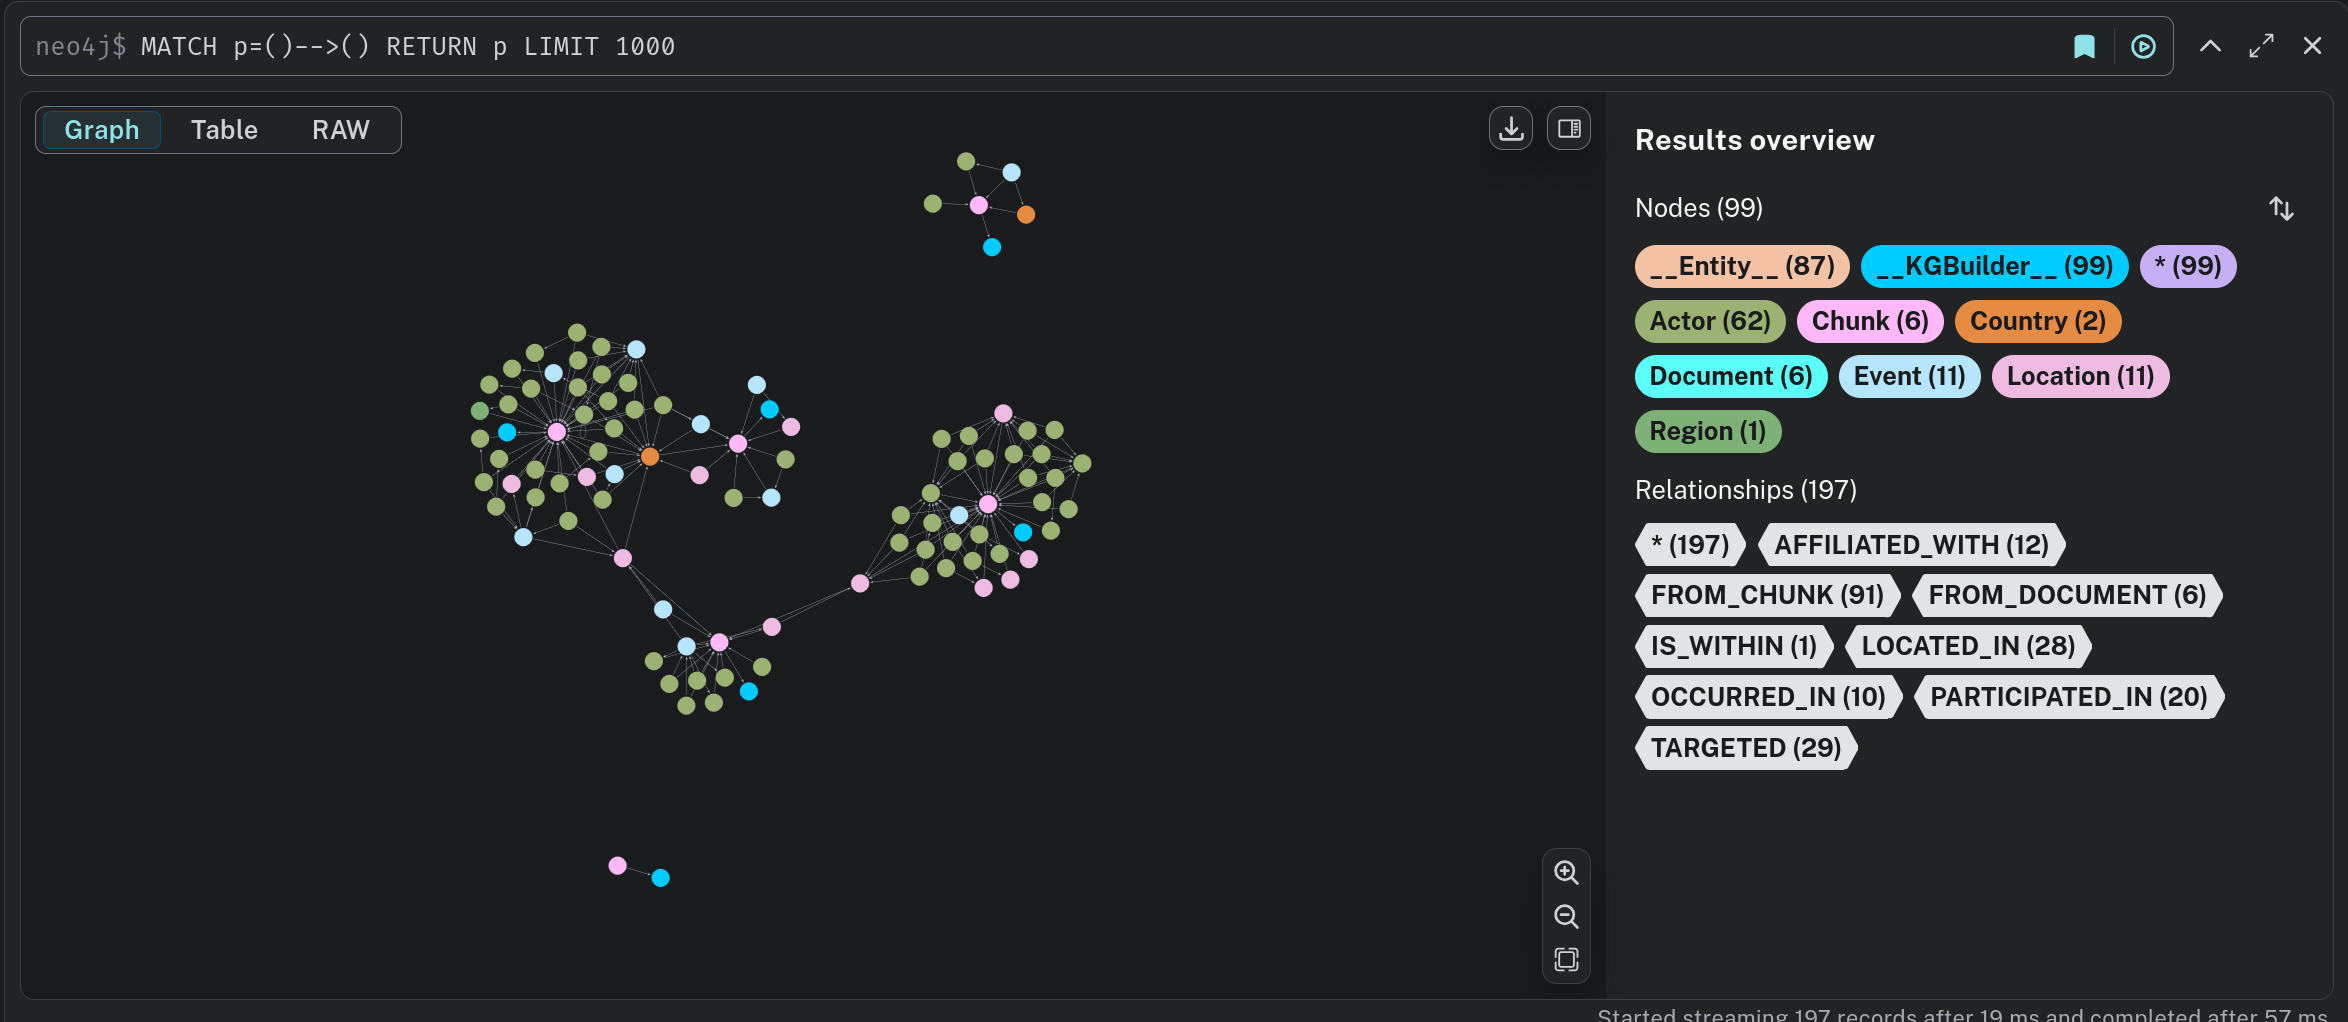

Running the code again should NOT introduce new nodes if the code is well implemented, but just duplicate the number of text chunks and documents in the graph.

Running the code again with the `spaCy` resolver takes 1 minute 12 seconds, and results in **122 nodes** (23% more nodes) and **299 relationships** (52% more edges, as most of them are duplicated). Regarding the nodes, the chunk and document nodes will be duplicated (which explains 12 out of the 23 new nodes), but there are some nodes that, oddly enough, end up being duplicated as well (for example), the event COVID-19 in the image below.

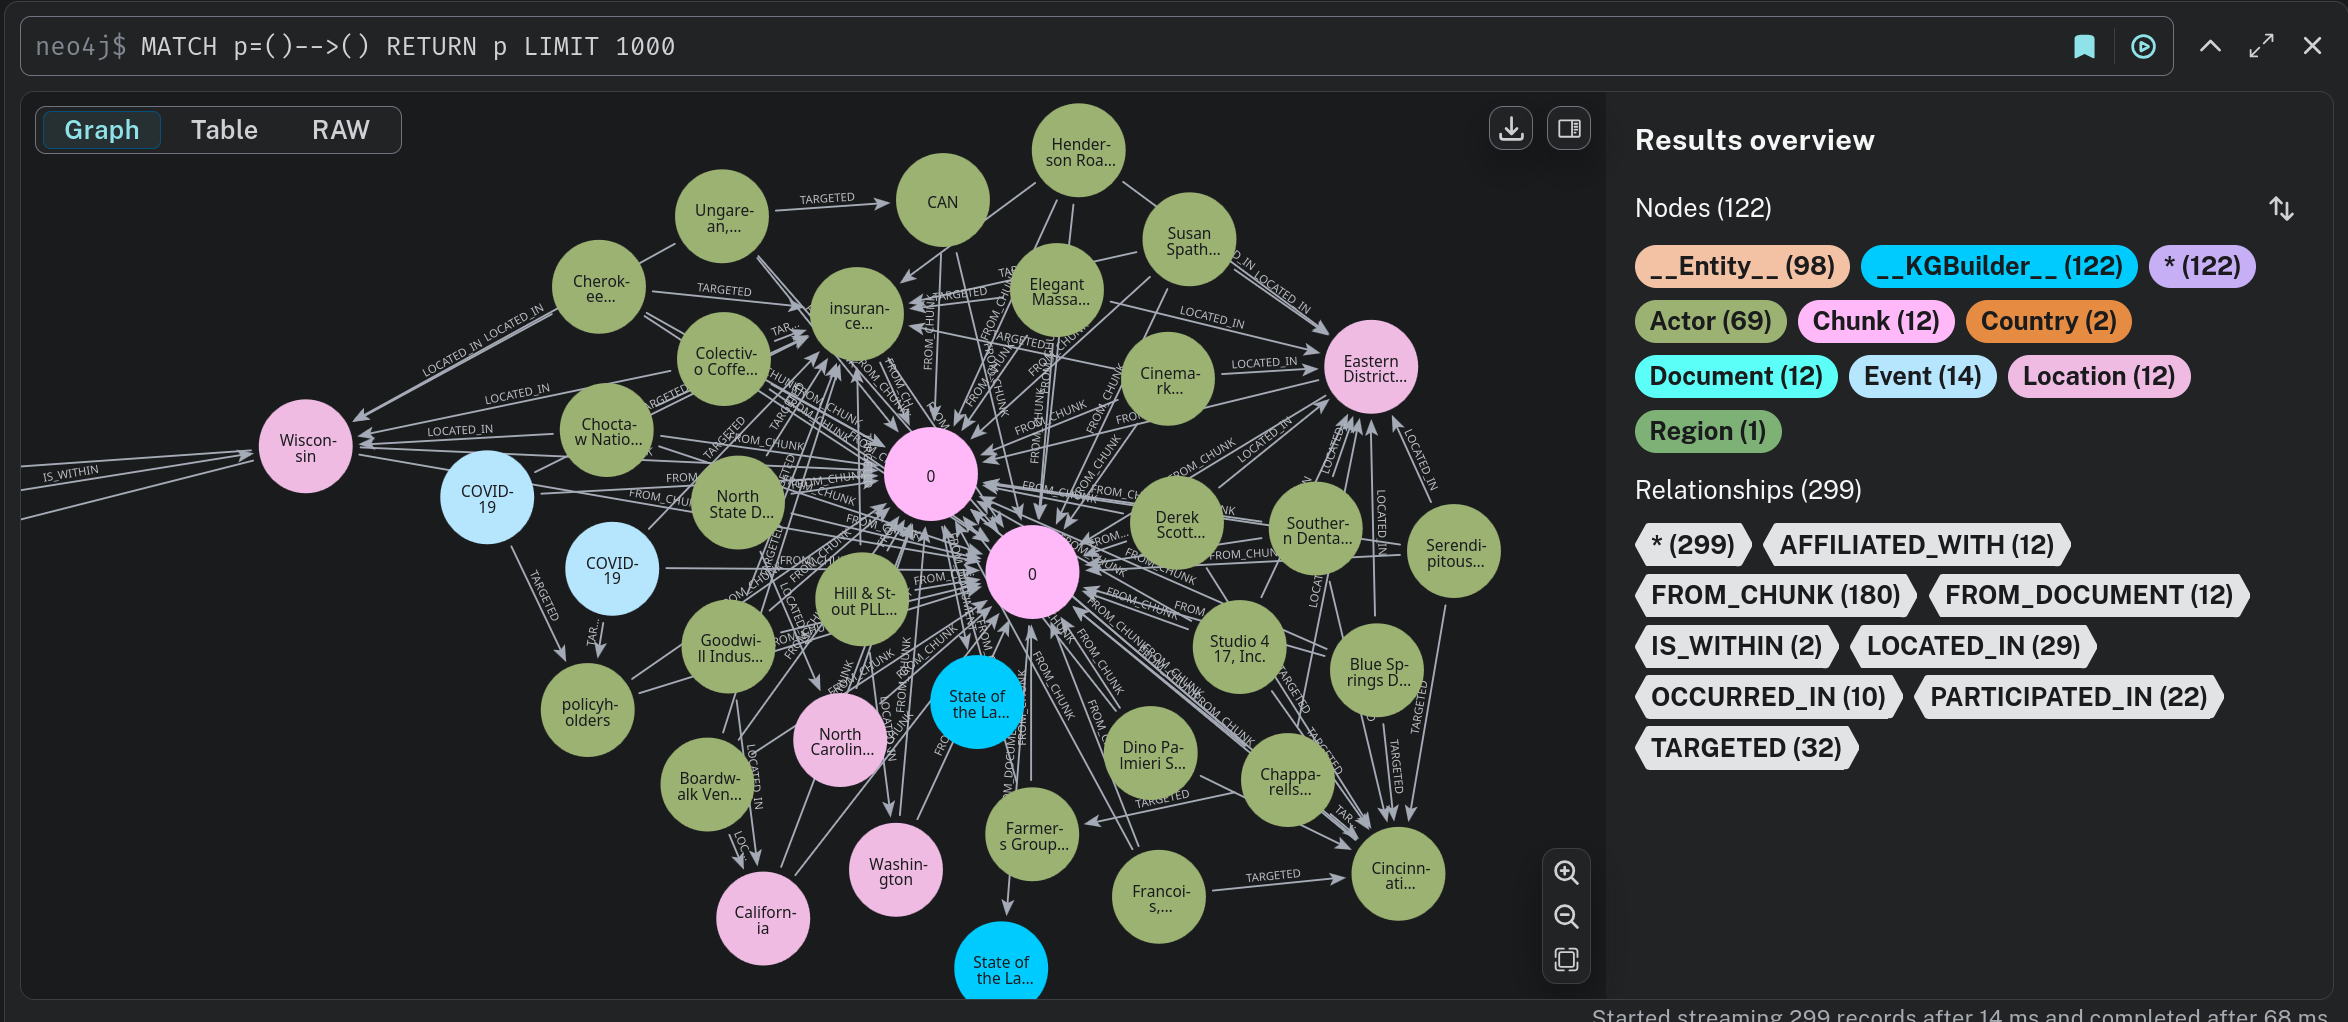

### B. Using the `FuzzyMatchResolver`

In [ ]:
# Example usage code
async def main():

    # Load configuration and setup

    script_dir = os.getcwd()

    # script_dir = os.path.dirname(os.path.abspath(__file__))  # Uncomment if running as a script

    # Load environment variables from a .env file
    dotenv_path = os.path.join(script_dir, '.env')
    load_dotenv(dotenv_path, override=True)

    # Open configuration file from JSON format
    config_path = os.path.join(script_dir, 'kg_building_config.json')
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    
    # Neo4j connection
    neo4j_uri = os.getenv('NEO4J_URI')
    neo4j_username = os.getenv('NEO4J_USERNAME')
    neo4j_password = os.getenv('NEO4J_PASSWORD')
    gemini_api_key = os.getenv('GEMINI_API_KEY')
    
    # Check if gemini_api_key is set
    if gemini_api_key:
        pass
    else:
        raise ValueError("Gemini API key is not set. Please provide a valid API key.")

    # Initialize LLM
    llm = GeminiLLM(
        model_name=config['llm_config']['model_name'],
        google_api_key=gemini_api_key,
        model_params=config['llm_config']['model_params']
    )
    
    # Initialize embedder
    embedder = SentenceTransformerEmbeddings(model=config['embedder_config']['model_name'])
    
    # Configure text splitter
    text_splitter_config = config['text_splitter_config']
    
    # Load data
    df_path = os.path.join(script_dir, 'FILTERED_DATAFRAME.parquet')
    df = pl.read_parquet(df_path)

    # Convert 'date' column to string format (from YYYYMMDD to YYYY-MM-DD)
    df = df.with_columns(pl.col('date').cast(pl.String))
    df = df.with_columns(pl.col('date').str.strptime(pl.Date, format='%Y%m%d'))
    df = df.with_columns(pl.col('date').dt.strftime('%Y-%m-%d'))

    # Create subset of the dataframe for testing
    df = df.head(10)
    
    # Create the pipeline - use with statement to ensure proper resource management
    # and to ensure the driver is closed after use
    with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:
        
        # Initialize entity resolver
        resolver = FuzzyMatchResolver(  # Merge nodes with same label and similar textual properties
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_properties=["name"],  # Properties to use for resolution (default is "name")
            similarity_threshold=0.8,  # The similarity threshold above which nodes are merged (default is 0.8). Higher threshold will result in less false positives, but may miss some matches. 
        )

        # Initialize the custom KG pipeline
        kg_pipeline = CustomKGPipeline(
            llm=llm,
            driver=driver,
            embedder=embedder,
            schema_config=config['schema_config'],
            prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None,
            text_splitter_config=text_splitter_config,
            resolver=resolver,
            examples_config=None,
            on_error='RAISE',
            batch_size=1000,
            max_concurrency=5
        )
        
        # Define metadata mapping (document properties additional to base field 
        # to dataframe columns)
        metadata_mapping = {
            "source": "url",
            "published_date": "date"
        }
        
        # Process the dataframe
        results = await build_kg_from_df(
            kg_pipeline=kg_pipeline,
            df=df,
            document_base_field='title',
            text_column='full_text',
            document_metadata_mapping=metadata_mapping,
            document_id_column=None  # Use default document ID generation
        )
    
    return results

# Asyncio event loop to run the main function in a Jupyter notebook
results = await main()
print(f"Processed {len(results)} documents")

# # Asyncio event loop to run the main function in a script
# if __name__ == "__main__":
#     results = asyncio.run(main())
#     print(f"Processed {len(results)} documents")

Processing row 1 of 10
Result: run_id='a17ceebd-598c-4b52-9b1b-1e351945bcdb' result={'resolver': {'number_of_nodes_to_resolve': 122, 'number_of_created_nodes': 16}}
Elapsed time: 24.08 seconds
Estimated time remaining: 216.71 seconds

Processing row 2 of 10
Result: run_id='7b82f83e-8174-4268-9754-ff5c3c67d247' result={'resolver': {'number_of_nodes_to_resolve': 122, 'number_of_created_nodes': 23}}
Elapsed time: 42.66 seconds
Estimated time remaining: 170.65 seconds

Processing row 3 of 10
Result: run_id='83214086-231d-4edb-896a-56422fdf567b' result={'resolver': {'number_of_nodes_to_resolve': 93, 'number_of_created_nodes': 10}}
Elapsed time: 48.71 seconds
Estimated time remaining: 113.65 seconds

Processing row 4 of 10
Skipping row 4 due to empty text
Elapsed time: 48.71 seconds
Estimated time remaining: 73.06 seconds

Processing row 5 of 10
Result: run_id='2aaf3421-0cde-48f7-874b-efec8b7c296c' result={'resolver': {'number_of_nodes_to_resolve': 162, 'number_of_created_nodes': 12}}
Elapse

Runtime for the introduction of the first nodes in the graph: 1 min.
- Number of nodes: 81.
- Number of edges: 116.

After 2nd runtime (which takes 1 min. and 30 seconds):
- Number of nodes: 137 (70% more nodes).
- Number of edges: 350 (202% more edges).

### C. Using the `SinglePropertyExactMatchResolver`

In [ ]:
# Example usage code
async def main():

    # Load configuration and setup

    script_dir = os.getcwd()

    # script_dir = os.path.dirname(os.path.abspath(__file__))  # Uncomment if running as a script

    # Load environment variables from a .env file
    dotenv_path = os.path.join(script_dir, '.env')
    load_dotenv(dotenv_path, override=True)

    # Open configuration file from JSON format
    config_path = os.path.join(script_dir, 'kg_building_config.json')
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    
    # Neo4j connection
    neo4j_uri = os.getenv('NEO4J_URI')
    neo4j_username = os.getenv('NEO4J_USERNAME')
    neo4j_password = os.getenv('NEO4J_PASSWORD')
    gemini_api_key = os.getenv('GEMINI_API_KEY')
    
    # Check if gemini_api_key is set
    if gemini_api_key:
        pass
    else:
        raise ValueError("Gemini API key is not set. Please provide a valid API key.")

    # Initialize LLM
    llm = GeminiLLM(
        model_name=config['llm_config']['model_name'],
        google_api_key=gemini_api_key,
        model_params=config['llm_config']['model_params']
    )
    
    # Initialize embedder
    embedder = SentenceTransformerEmbeddings(model=config['embedder_config']['model_name'])
    
    # Configure text splitter
    text_splitter_config = config['text_splitter_config']
    
    # Load data
    df_path = os.path.join(script_dir, 'FILTERED_DATAFRAME.parquet')
    df = pl.read_parquet(df_path)

    # Convert 'date' column to string format (from YYYYMMDD to YYYY-MM-DD)
    df = df.with_columns(pl.col('date').cast(pl.String))
    df = df.with_columns(pl.col('date').str.strptime(pl.Date, format='%Y%m%d'))
    df = df.with_columns(pl.col('date').dt.strftime('%Y-%m-%d'))

    # Create subset of the dataframe for testing
    df = df.head(10)
    
    # Create the pipeline - use with statement to ensure proper resource management
    # and to ensure the driver is closed after use
    with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:
        
        # Initialize entity resolver
        resolver = SinglePropertyExactMatchResolver(  # Merge nodes with same label and exact property
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_property="name"  # Property to use for resolution (default is "name")
        )

        # Initialize the custom KG pipeline
        kg_pipeline = CustomKGPipeline(
            llm=llm,
            driver=driver,
            embedder=embedder,
            schema_config=config['schema_config'],
            prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None,
            text_splitter_config=text_splitter_config,
            resolver=resolver,
            examples_config=None,
            on_error='RAISE',
            batch_size=1000,
            max_concurrency=5,
        )
        
        # Define metadata mapping (document properties additional to base field 
        # to dataframe columns)
        metadata_mapping = {
            "source": "url",
            "published_date": "date"
        }
        
        # Process the dataframe
        results = await build_kg_from_df(
            kg_pipeline=kg_pipeline,
            df=df,
            document_base_field='title',
            text_column='full_text',
            document_metadata_mapping=metadata_mapping,
            document_id_column=None  # Use default document ID generation
        )
    
    return results

# Asyncio event loop to run the main function in a Jupyter notebook
results = await main()
print(f"Processed {len(results)} documents")

# # Asyncio event loop to run the main function in a script
# if __name__ == "__main__":
#     results = asyncio.run(main())
#     print(f"Processed {len(results)} documents")

Processing row 1 of 10
Result: run_id='5a699799-3724-43ec-9e77-7352ca82e282' result={'resolver': {'number_of_nodes_to_resolve': 228, 'number_of_created_nodes': 215}}
Elapsed time: 23.73 seconds
Estimated time remaining: 213.59 seconds

Processing row 2 of 10
Result: run_id='218db041-f74d-4a8b-9da3-a88c95070ca9' result={'resolver': {'number_of_nodes_to_resolve': 244, 'number_of_created_nodes': 221}}
Elapsed time: 36.12 seconds
Estimated time remaining: 144.47 seconds

Processing row 3 of 10
Result: run_id='864bf629-b5d8-4be8-9ead-47c07e15870d' result={'resolver': {'number_of_nodes_to_resolve': 234, 'number_of_created_nodes': 221}}
Elapsed time: 41.05 seconds
Estimated time remaining: 95.78 seconds

Processing row 4 of 10
Skipping row 4 due to empty text
Elapsed time: 41.05 seconds
Estimated time remaining: 61.58 seconds

Processing row 5 of 10


LLM response has improper format for chunk_index=0


Result: run_id='25a44568-548f-4373-9257-7fc964c19667' result={'resolver': {'number_of_nodes_to_resolve': 221, 'number_of_created_nodes': 221}}
Elapsed time: 58.18 seconds
Estimated time remaining: 58.18 seconds

Processing row 6 of 10
Skipping row 6 due to empty text
Elapsed time: 58.18 seconds
Estimated time remaining: 38.79 seconds

Processing row 7 of 10
Skipping row 7 due to empty text
Elapsed time: 58.18 seconds
Estimated time remaining: 24.93 seconds

Processing row 8 of 10
Result: run_id='8fee76c0-9963-49f8-a4d7-533873568c31' result={'resolver': {'number_of_nodes_to_resolve': 231, 'number_of_created_nodes': 221}}
Elapsed time: 61.93 seconds
Estimated time remaining: 15.48 seconds

Processing row 9 of 10
Skipping row 9 due to empty text
Elapsed time: 61.93 seconds
Estimated time remaining: 6.88 seconds

Processing row 10 of 10
Result: run_id='e32e1db6-073f-4807-ac0b-a0ea5a46c33f' result={'resolver': {'number_of_nodes_to_resolve': 230, 'number_of_created_nodes': 221}}
Elapsed time

Runtime for the introduction of the first nodes in the graph: 1 min. 15 seconds.
- Number of nodes: 187.
- Number of edges: 337.

After 2nd runtime (which takes 1 min. and 10 seconds):
- Number of nodes: 245 (31% more nodes).
- Number of edges: 455 (35% more edges).

### Insights

- The **spaCy** resolver is the one which yields the smallest graph, and the one which resolves the most nodes among the default resolvers. However, it seems to be the slowest resolver.
- The `FuzzyMatchResolver` does not seem to work very well out of the box, as the number of duplicate nodes and edges increases significantly.
- Finally, the `SinglePropertyExactMatchResolver` produces the largest graph among the 3 resolvers, but prunes a relatively decent amount of nodes and edges when running the instance twice.

### Ex-post resolver

Note that it is also possible to run a resolver ex-post, after the graph has been created (see the [user guide for the resolvers](https://neo4j.com/docs/neo4j-graphrag-python/current/user_guide_kg_builder.html#entity-resolver)) and outside the pipeline of the KG building.

In [ ]:
# Neo4j connection
neo4j_uri = os.getenv('NEO4J_URI')
neo4j_username = os.getenv('NEO4J_USERNAME')
neo4j_password = os.getenv('NEO4J_PASSWORD')

with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:
        
        # Initialize entity resolver
        resolver = SpaCySemanticMatchResolver(  # Merge nodes with same label and similar textual properties
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_properties=["name"],  # Properties to use for resolution (default is "name")
            similarity_threshold=0.8,  # The similarity threshold above which nodes are merged (default is 0.8). Higher threshold will result in less false positives, but may miss some matches. 
            spacy_model="en_core_web_lg"  # spaCy model to use for resolution (default is "en_core_web_lg")
        )

        result = await resolver.run()
        print("Entity resolution completed.")

print(result)

Entity resolution completed.
number_of_nodes_to_resolve=164 number_of_created_nodes=0


## 2.3. Creating the KG without a schema

In [ ]:
# Example usage code
async def main():

    # Load configuration and setup

    script_dir = os.getcwd()

    # script_dir = os.path.dirname(os.path.abspath(__file__))  # Uncomment if running as a script

    # Load environment variables from a .env file
    dotenv_path = os.path.join(script_dir, '.env')
    load_dotenv(dotenv_path, override=True)

    # Open configuration file from JSON format
    config_path = os.path.join(script_dir, 'kg_building_config.json')
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    
    # Neo4j connection
    neo4j_uri = os.getenv('NEO4J_URI')
    neo4j_username = os.getenv('NEO4J_USERNAME')
    neo4j_password = os.getenv('NEO4J_PASSWORD')
    gemini_api_key = os.getenv('GEMINI_API_KEY')
    
    # Check if gemini_api_key is set
    if gemini_api_key:
        pass
    else:
        raise ValueError("Gemini API key is not set. Please provide a valid API key.")

    # Initialize LLM
    llm = GeminiLLM(
        model_name=config['llm_config']['model_name'],
        google_api_key=gemini_api_key,
        model_params=config['llm_config']['model_params']
    )
    
    # Initialize embedder
    embedder = SentenceTransformerEmbeddings(model=config['embedder_config']['model_name'])
    
    # Configure text splitter
    text_splitter_config = config['text_splitter_config']
    
    # Load data
    df_path = os.path.join(script_dir, 'FILTERED_DATAFRAME.parquet')
    df = pl.read_parquet(df_path)

    # Convert 'date' column to string format (from YYYYMMDD to YYYY-MM-DD)
    df = df.with_columns(pl.col('date').cast(pl.String))
    df = df.with_columns(pl.col('date').str.strptime(pl.Date, format='%Y%m%d'))
    df = df.with_columns(pl.col('date').dt.strftime('%Y-%m-%d'))

    # Create subset of the dataframe for testing
    df = df.head(10)
    
    # Create the pipeline - use with statement to ensure proper resource management
    # and to ensure the driver is closed after use
    with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:
        
        # Initialize entity resolver
        resolver = SpaCySemanticMatchResolver(  # Merge nodes with same label and similar textual properties
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_properties=["name"],  # Properties to use for resolution (default is "name")
            similarity_threshold=0.8,  # The similarity threshold above which nodes are merged (default is 0.8). Higher threshold will result in less false positives, but may miss some matches. 
            spacy_model="en_core_web_lg"  # spaCy model to use for resolution (default is "en_core_web_lg")
        )

        # Initialize the custom KG pipeline
        kg_pipeline = CustomKGPipeline(
            llm=llm,
            driver=driver,
            embedder=embedder,
            schema_config=None,  # Don't use schema config for this example (same behavior as if "create_schema": false in the config and here config['schema_config'] is passed)
            prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None,
            text_splitter_config=text_splitter_config,
            resolver=resolver,
            examples_config=None,
            on_error='RAISE',
            batch_size=1000,
            max_concurrency=5,
        )
        
        # Define metadata mapping (document properties additional to base field 
        # to dataframe columns)
        metadata_mapping = {
            "source": "url",
            "published_date": "date"
        }
        
        # Process the dataframe
        results = await build_kg_from_df(
            kg_pipeline=kg_pipeline,
            df=df,
            document_base_field='title',
            text_column='full_text',
            document_metadata_mapping=metadata_mapping,
            document_id_column=None  # Use default document ID generation
        )
    
    return results

# Asyncio event loop to run the main function in a Jupyter notebook
results = await main()
print(f"Processed {len(results)} documents")

# # Asyncio event loop to run the main function in a script
# if __name__ == "__main__":
#     results = asyncio.run(main())
#     print(f"Processed {len(results)} documents")

Processing row 1 of 10
Result: run_id='95b9dfda-d88e-4c0d-98b0-2c91ac08b9de' result={'resolver': {'number_of_nodes_to_resolve': 67, 'number_of_created_nodes': 5}}
Elapsed time: 28.99 seconds
Estimated time remaining: 260.90 seconds

Processing row 2 of 10
Result: run_id='c4273098-e9fe-4112-b22d-a909d2bdcb18' result={'resolver': {'number_of_nodes_to_resolve': 67, 'number_of_created_nodes': 0}}
Elapsed time: 38.26 seconds
Estimated time remaining: 153.03 seconds

Processing row 3 of 10
Result: run_id='d4e2cd0a-d9e0-45e3-b798-f57b42601a09' result={'resolver': {'number_of_nodes_to_resolve': 86, 'number_of_created_nodes': 0}}
Elapsed time: 48.58 seconds
Estimated time remaining: 113.35 seconds

Processing row 4 of 10
Skipping row 4 due to empty text
Elapsed time: 48.58 seconds
Estimated time remaining: 72.86 seconds

Processing row 5 of 10
Result: run_id='2fd3a9f4-1368-4115-a699-cd03c0ee6c16' result={'resolver': {'number_of_nodes_to_resolve': 130, 'number_of_created_nodes': 3}}
Elapsed time

Without passing a schema:
1. The pipeline takes a bit longer (as the LLM has to add some "creativity" in order to design the entities and edges).
2. The number of nodes and edges increases (compared to the situation where a schema is introduced).
3. There is a considerable randomness of the entities created, with few common entities.

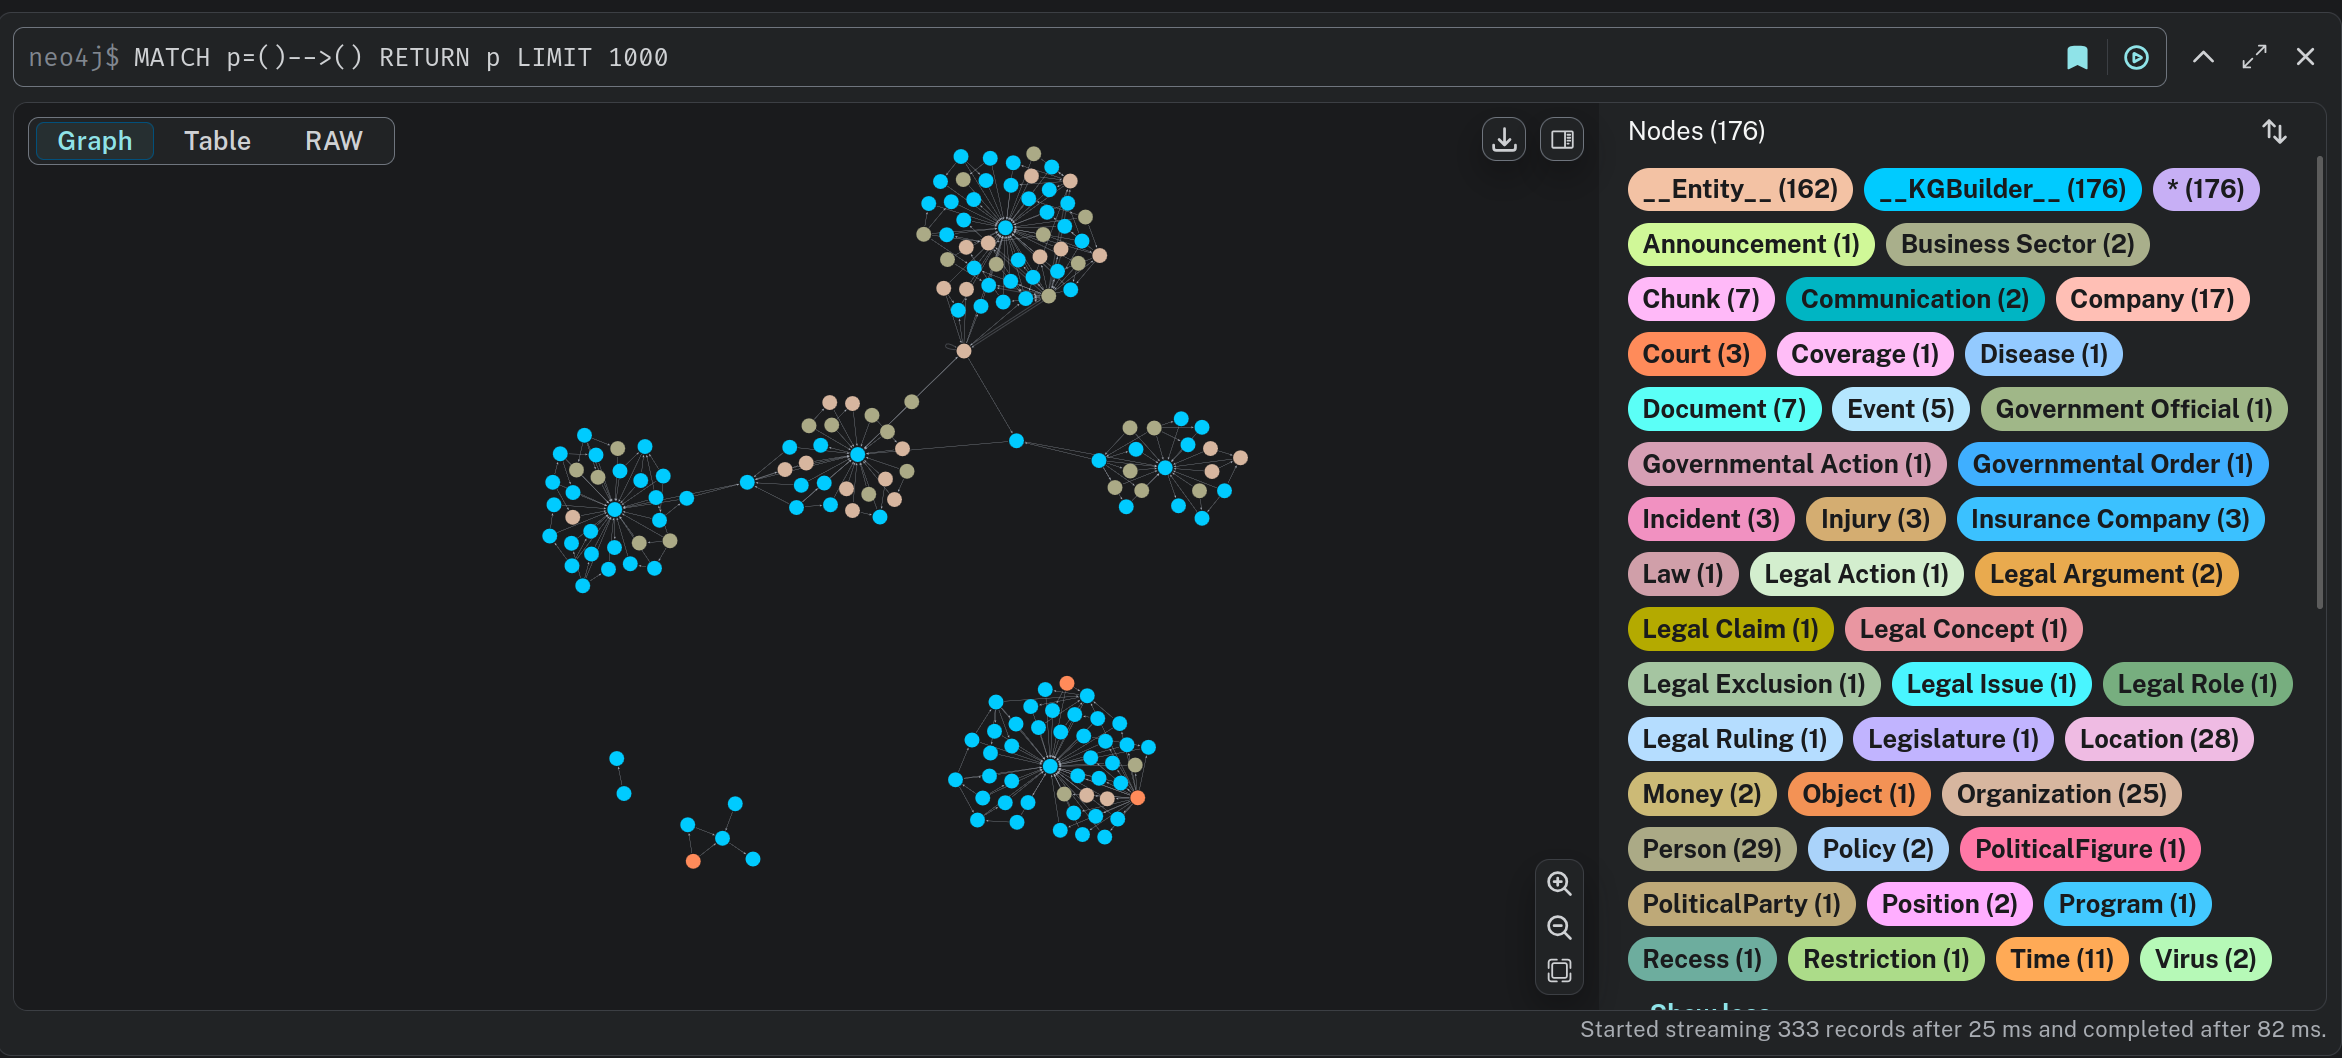

## 2.4. Passing examples for few-shot learning

Ensure that the `pass_examples` key in the JSON configuration file is set to `true`.

In [ ]:
# Example usage code
async def main():

    # Load configuration and setup

    script_dir = os.getcwd()

    # script_dir = os.path.dirname(os.path.abspath(__file__))  # Uncomment if running as a script

    # Load environment variables from a .env file
    dotenv_path = os.path.join(script_dir, '.env')
    load_dotenv(dotenv_path, override=True)

    # Open configuration file from JSON format
    config_path = os.path.join(script_dir, 'kg_building_config.json')
    with open(config_path, 'r') as config_file:
        config = json.load(config_file)
    
    # Neo4j connection
    neo4j_uri = os.getenv('NEO4J_URI')
    neo4j_username = os.getenv('NEO4J_USERNAME')
    neo4j_password = os.getenv('NEO4J_PASSWORD')
    gemini_api_key = os.getenv('GEMINI_API_KEY')
    
    # Check if gemini_api_key is set
    if gemini_api_key:
        pass
    else:
        raise ValueError("Gemini API key is not set. Please provide a valid API key.")

    # Initialize LLM
    llm = GeminiLLM(
        model_name=config['llm_config']['model_name'],
        google_api_key=gemini_api_key,
        model_params=config['llm_config']['model_params']
    )
    
    # Initialize embedder
    embedder = SentenceTransformerEmbeddings(model=config['embedder_config']['model_name'])
    
    # Configure text splitter
    text_splitter_config = config['text_splitter_config']
    
    # Load data
    df_path = os.path.join(script_dir, 'FILTERED_DATAFRAME.parquet')
    df = pl.read_parquet(df_path)

    # Convert 'date' column to string format (from YYYYMMDD to YYYY-MM-DD)
    df = df.with_columns(pl.col('date').cast(pl.String))
    df = df.with_columns(pl.col('date').str.strptime(pl.Date, format='%Y%m%d'))
    df = df.with_columns(pl.col('date').dt.strftime('%Y-%m-%d'))

    # Create subset of the dataframe for testing
    df = df.head(10)
    
    # Create the pipeline - use with statement to ensure proper resource management
    # and to ensure the driver is closed after use
    with neo4j.GraphDatabase.driver(neo4j_uri, auth=(neo4j_username, neo4j_password)) as driver:
        
        # Initialize entity resolver
        resolver = SpaCySemanticMatchResolver(  # Merge nodes with same label and similar textual properties
            driver,
            filter_query=None,  # "WHERE (entity)-[:FROM_CHUNK]->(:Chunk)-[:FROM_DOCUMENT]->(doc:Document {id = 'docId'}",  # Used to reduce the resolution scope to a specific document
            resolve_properties=["name"],  # Properties to use for resolution (default is "name")
            similarity_threshold=0.8,  # The similarity threshold above which nodes are merged (default is 0.8). Higher threshold will result in less false positives, but may miss some matches. 
            spacy_model="en_core_web_lg"  # spaCy model to use for resolution (default is "en_core_web_lg")
        )

        # Initialize the custom KG pipeline
        kg_pipeline = CustomKGPipeline(
            llm=llm,
            driver=driver,
            embedder=embedder,
            schema_config=config['schema_config'],
            prompt_template=config['prompt_template_config']['template'] if config['prompt_template_config'].get('use_default') == False else None,
            text_splitter_config=text_splitter_config,
            resolver=resolver,
            examples_config=config['examples_config'],  # Use None if no examples are provided
            on_error='RAISE',
            batch_size=1000,
            max_concurrency=5
        )
        
        # Define metadata mapping (document properties additional to base field 
        # to dataframe columns)
        metadata_mapping = {
            "source": "url",
            "published_date": "date"
        }
        
        # Process the dataframe
        results = await build_kg_from_df(
            kg_pipeline=kg_pipeline,
            df=df,
            document_base_field='title',
            text_column='full_text',
            document_metadata_mapping=metadata_mapping,
            document_id_column=None  # Use default document ID generation
        )
    
    return results

# Asyncio event loop to run the main function in a Jupyter notebook
results = await main()
print(f"Processed {len(results)} documents")

# # Asyncio event loop to run the main function in a script
# if __name__ == "__main__":
#     results = asyncio.run(main())
#     print(f"Processed {len(results)} documents")

Processing row 1 of 10


LLM response has improper format for chunk_index=0
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: __Entity__)} {position: line: 2, column: 27, offset: 27} for query: "\n            MATCH (entity:__Entity__)\n            UNWIND labels(entity) AS lab\n            WITH lab, entity\n            WHERE NOT lab IN ['__Entity__', '__KGBuilder__']\n            WITH lab, collect({ id: elementId(entity), name: entity.name }) AS labelCluster\n            RETURN lab, labelCluster\n        "
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGN

Result: run_id='a697eeab-60f8-4ce4-912b-d130427d50f2' result={'resolver': {'number_of_nodes_to_resolve': 0, 'number_of_created_nodes': 0}}
Elapsed time: 27.32 seconds
Estimated time remaining: 245.91 seconds

Processing row 2 of 10


LLM response has improper format for chunk_index=0
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownLabelWarning} {category: UNRECOGNIZED} {title: The provided label is not in the database.} {description: One of the labels in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing label name is: __Entity__)} {position: line: 2, column: 27, offset: 27} for query: "\n            MATCH (entity:__Entity__)\n            UNWIND labels(entity) AS lab\n            WITH lab, entity\n            WHERE NOT lab IN ['__Entity__', '__KGBuilder__']\n            WITH lab, collect({ id: elementId(entity), name: entity.name }) AS labelCluster\n            RETURN lab, labelCluster\n        "
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGN

Result: run_id='d0d02481-3bde-44e0-83c7-1b033df7bfae' result={'resolver': {'number_of_nodes_to_resolve': 0, 'number_of_created_nodes': 0}}
Elapsed time: 45.23 seconds
Estimated time remaining: 180.92 seconds

Processing row 3 of 10
Result: run_id='57ade4f0-a18c-4154-9e11-4c5a060ec1a3' result={'resolver': {'number_of_nodes_to_resolve': 10, 'number_of_created_nodes': 0}}
Elapsed time: 50.96 seconds
Estimated time remaining: 118.90 seconds

Processing row 4 of 10
Skipping row 4 due to empty text
Elapsed time: 50.96 seconds
Estimated time remaining: 76.43 seconds

Processing row 5 of 10
Result: run_id='455babd3-67fa-4e8b-811f-c886c668d162' result={'resolver': {'number_of_nodes_to_resolve': 57, 'number_of_created_nodes': 5}}
Elapsed time: 68.02 seconds
Estimated time remaining: 68.02 seconds

Processing row 6 of 10
Skipping row 6 due to empty text
Elapsed time: 68.02 seconds
Estimated time remaining: 45.35 seconds

Processing row 7 of 10
Skipping row 7 due to empty text
Elapsed time: 68.02 

LLM response has improper format for chunk_index=0


Result: run_id='63890a77-0ab0-49b2-8ecc-5ba39ab3c6c5' result={'resolver': {'number_of_nodes_to_resolve': 71, 'number_of_created_nodes': 0}}
Elapsed time: 84.72 seconds
Estimated time remaining: 0.00 seconds

Processed 10 documents


Obviously, the examples provided have to be useful for the LLM.